In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
import joblib
import os

df = pd.read_csv("../data/cleaned_responses.csv")

print("Original dataset shape:", df.shape)
print(df['diabetes_diagnosed'].value_counts())

Original dataset shape: (314, 14)
diabetes_diagnosed
0    211
1    103
Name: count, dtype: int64


In [15]:
# Feature selection and preparation

feature_cols = ['gender', 'pregnancies', 'age', 'glucose', 'blood_pressure', 
                'weight', 'height', 'insulin', 'bmi', 'physically_active', 
                'smoking', 'junk_food', 'family_history']

X = df[feature_cols].copy()
y = df['diabetes_diagnosed'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Features used: {feature_cols}")

# Check correlation with target variable
print("\nCorrelation with target variable:")
correlations = X.corrwith(y).sort_values(ascending=False)
print(correlations)


Feature matrix shape: (314, 13)
Features used: ['gender', 'pregnancies', 'age', 'glucose', 'blood_pressure', 'weight', 'height', 'insulin', 'bmi', 'physically_active', 'smoking', 'junk_food', 'family_history']

Correlation with target variable:
blood_pressure       0.802786
age                  0.713982
glucose              0.568363
weight               0.559851
height               0.341301
family_history       0.334295
smoking              0.295420
pregnancies          0.272878
bmi                  0.230439
physically_active    0.110218
gender               0.078578
insulin              0.001255
junk_food           -0.052927
dtype: float64


In [ ]:

complete_data = df[feature_cols + ['diabetes_diagnosed']].dropna()

# Separate features and target
X = complete_data[feature_cols].copy()
y = complete_data['diabetes_diagnosed'].copy()

print(f"\nFinal feature matrix shape: {X.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set target distribution:")
print(y_train.value_counts())
print(f"Training set diabetes prevalence: {(y_train.sum() / len(y_train)) * 100:.2f}%")

print(f"\nTest set target distribution:")
print(y_test.value_counts())
print(f"Test set diabetes prevalence: {(y_test.sum() / len(y_test)) * 100:.2f}%")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Rows removed: 0
Percentage of data retained: 100.00%

Final feature matrix shape: (314, 13)
Missing values in final dataset:
0

Training set target distribution:
diabetes_diagnosed
0    169
1     82
Name: count, dtype: int64
Training set diabetes prevalence: 32.67%

Test set target distribution:
diabetes_diagnosed
0    42
1    21
Name: count, dtype: int64
Test set diabetes prevalence: 33.33%


In [19]:
# Logistic Regression Model Training

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000, 5000, 10000]  
}

logreg = LogisticRegression(random_state=42)

grid_search = GridSearchCV(
    logreg, param_grid, cv=5, scoring='f1', n_jobs=1, verbose=1
)

print("Fitting models with different parameter combinations...")
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_logreg = grid_search.best_estimator_
best_logreg.fit(X_train_scaled, y_train)
print("Model training completed!")


Fitting models with different parameter combinations...
Fitting 5 folds for each of 80 candidates, totalling 400 fits


/Users/91life/Desktop/diabetes-project/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Best parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.9347
Model training completed!


In [20]:
# Model Evaluation

# Make predictions
y_pred = best_logreg.predict(X_test_scaled)
y_pred_proba = best_logreg.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

# Confusion Matrix
print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification Report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Cross-validation scores
print("\nCross-validation scores:")
cv_scores = cross_val_score(best_logreg, X_train_scaled, y_train, cv=5, scoring='f1')
print(f"CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



Model Performance Metrics:
Accuracy: 0.9683
Precision: 0.9524
Recall: 0.9524
F1-Score: 0.9524
AUC-ROC: 0.9739

Confusion Matrix:
[[41  1]
 [ 1 20]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.95      0.95      0.95        21

    accuracy                           0.97        63
   macro avg       0.96      0.96      0.96        63
weighted avg       0.97      0.97      0.97        63


Cross-validation scores:
CV F1-Score: 0.9347 (+/- 0.0578)



Feature Importance (by coefficient magnitude):
              feature  coefficient  abs_coefficient
4      blood_pressure     3.045844         3.045844
2                 age     1.339324         1.339324
9   physically_active     1.032512         1.032512
12     family_history     0.668475         0.668475
7             insulin     0.629911         0.629911
6              height    -0.228635         0.228635
1         pregnancies     0.105055         0.105055
0              gender    -0.071640         0.071640
10            smoking     0.026333         0.026333
3             glucose     0.000000         0.000000
5              weight     0.000000         0.000000
8                 bmi     0.000000         0.000000
11          junk_food     0.000000         0.000000


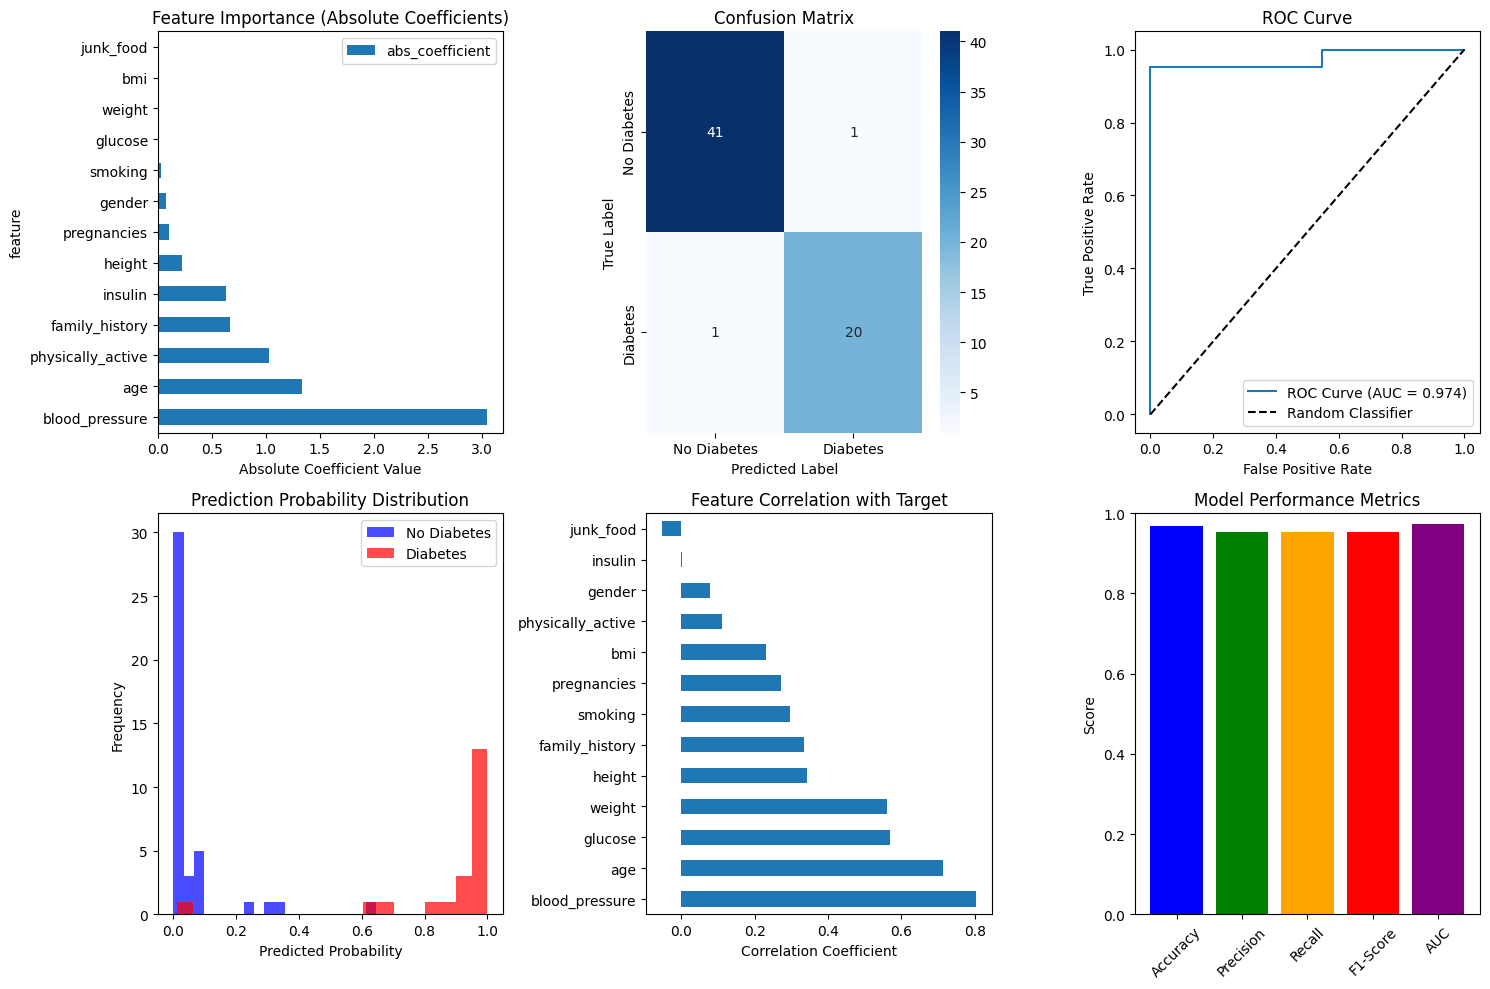

In [21]:
# Feature Importance Analysis

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': best_logreg.coef_[0],
    'abs_coefficient': np.abs(best_logreg.coef_[0])
})

feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print("\nFeature Importance (by coefficient magnitude):")
print(feature_importance)

# Visualizations
plt.figure(figsize=(15, 10))

# 1. Feature Importance Plot
plt.subplot(2, 3, 1)
feature_importance.plot(x='feature', y='abs_coefficient', kind='barh', ax=plt.gca())
plt.title('Feature Importance (Absolute Coefficients)')
plt.xlabel('Absolute Coefficient Value')

# 2. Confusion Matrix Heatmap
plt.subplot(2, 3, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 3. ROC Curve
plt.subplot(2, 3, 3)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# 4. Prediction Probability Distribution
plt.subplot(2, 3, 4)
plt.hist(y_pred_proba[y_test == 0], bins=20, alpha=0.7, label='No Diabetes', color='blue')
plt.hist(y_pred_proba[y_test == 1], bins=20, alpha=0.7, label='Diabetes', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Prediction Probability Distribution')
plt.legend()

# 5. Feature Correlation with Target
plt.subplot(2, 3, 5)
correlations.plot(kind='barh')
plt.title('Feature Correlation with Target')
plt.xlabel('Correlation Coefficient')

# 6. Model Performance Summary
plt.subplot(2, 3, 6)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [accuracy, precision, recall, f1, auc]
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [ ]:
# Model Interpretation and Saving

print("\nTop 5 Most Important Features:")
top_features = feature_importance.head()
for idx, row in top_features.iterrows():
    direction = "increases" if row['coefficient'] > 0 else "decreases"
    print(f"{row['feature']}: {direction} diabetes risk (coef: {row['coefficient']:.4f})")

print(f"\nModel Summary:")
print(f"- Total features used: {len(feature_cols)}")
print(f"- Complete data samples: {len(complete_data)}")
print(f"- Training samples: {len(X_train)}")
print(f"- Test samples: {len(X_test)}")
print(f"- Data retention rate: {(len(complete_data) / df.shape[0]) * 100:.2f}%")
print(f"- Best hyperparameters: {grid_search.best_params_}")
print(f"- Cross-validation F1-score: {grid_search.best_score_:.4f}")
print(f"- Test F1-score: {f1:.4f}")


model_path = "/Users/91life/Desktop/diabetes-project/models/"

os.makedirs(model_path, exist_ok=True)

joblib.dump(best_logreg, f"{model_path}logistic_regression_model.pkl")


Model Interpretation:

Top 5 Most Important Features:
blood_pressure: increases diabetes risk (coef: 3.0458)
age: increases diabetes risk (coef: 1.3393)
physically_active: increases diabetes risk (coef: 1.0325)
family_history: increases diabetes risk (coef: 0.6685)
insulin: increases diabetes risk (coef: 0.6299)

Model Summary:
- Total features used: 13
- Training samples: 251
- Test samples: 63
- Best hyperparameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
- Cross-validation F1-score: 0.9347
- Test F1-score: 0.9524

Model and scaler saved to: /Users/91life/Desktop/diabetes-project/models/
Logistic Regression training completed successfully!

Recommendations for Model Improvement:
1. Collect more data to increase sample size
2. Consider feature engineering (interaction terms, polynomial features)
3. Try ensemble methods (Random Forest, XGBoost)
4. Address class imbalance if present
5. Validate model on external dataset
